#### 該文件包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總醫療費用特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:醫療費用

#### 目的:檢測與醫療費用相關之變量，找出在醫療費用上具高風險的人

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats


In [ ]:
#讀入資料
df = pd.read_csv('insurance.csv')



In [13]:
# 檢查是否有缺失值
df.isnull().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
# 初步檢視資料
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# 2. 進行 One-Hot Encoding
# 使用 dtype=int 確保結果是 0 和 1 而非 True/False
# drop_first=True 移除重複資訊（例如 sex 只有男/女，知道不是男就一定是女，不需兩個欄位）
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=int)


# 資料編碼 (Encoding)我們在 get_dummies 中加入了 dtype=int。
# 這樣做是因為迴歸方程 $y = \beta_0 + \beta_1 x_1 + ...$ 
# 需要純數值運算。smoker_yes = 1：計算時會帶入係數（例如 $23,000 \times 1$）。
# smoker_yes = 0：該項影響力歸零。


print(df_encoded.head())

   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400         0           1                 0   
1   18  33.770         1   1725.55230         1           0                 0   
2   28  33.000         3   4449.46200         1           0                 0   
3   33  22.705         0  21984.47061         1           0                 1   
4   32  28.880         0   3866.85520         1           0                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0  


In [5]:
from sklearn import preprocessing

# 定義特徵 (X) 與 目標 (y)
# X 是我們用來預測的「線索」（年齡、BMI、是否抽菸等）
# y 是我們要預測的「結果」（醫療費用 charges）
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']


#建立MinMaxScaler物件
minmax = preprocessing.MinMaxScaler()
# 資料標準化
x_minmax = minmax.fit_transform(df_encoded[['age', 'bmi', 'children', 'charges', 'sex_male',
                                            'smoker_yes', 'region_northwest', 'region_southeast',
                                            'region_southwest']])

x_minmax= pd.DataFrame(x_minmax, columns=['age', 'bmi', 'children', 'charges', 'sex_male',
                                            'smoker_yes', 'region_northwest', 'region_southeast',
                                            'region_southwest'])

res_minmax = pd.concat([x_minmax.reset_index(drop=True), df_encoded['charges']], axis=1)
res_minmax

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges
0,0.021739,0.321227,0.0,0.251611,0.0,1.0,0.0,0.0,1.0,16884.92400
1,0.000000,0.479150,0.2,0.009636,1.0,0.0,0.0,1.0,0.0,1725.55230
2,0.217391,0.458434,0.6,0.053115,1.0,0.0,0.0,1.0,0.0,4449.46200
3,0.326087,0.181464,0.0,0.333010,1.0,0.0,1.0,0.0,0.0,21984.47061
4,0.304348,0.347592,0.0,0.043816,1.0,0.0,1.0,0.0,0.0,3866.85520
...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,0.403820,0.6,0.151299,1.0,0.0,1.0,0.0,0.0,10600.54830
1334,0.000000,0.429379,0.0,0.017305,0.0,0.0,0.0,0.0,0.0,2205.98080
1335,0.000000,0.562012,0.0,0.008108,0.0,0.0,0.0,1.0,0.0,1629.83350
1336,0.065217,0.264730,0.0,0.014144,0.0,0.0,0.0,0.0,1.0,2007.94500


In [ ]:
# 確認資料皆已轉型成功
print(df_encoded.dtypes)

age                   int64
bmi                 float64
children              int64
charges             float64
sex_male              int64
smoker_yes            int64
region_northwest      int64
region_southeast      int64
region_southwest      int64
dtype: object


In [8]:

# 分割訓練和測試
# 80%訓練集和 20%測試集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

#切割完之後確認訓練集和測試集矩陣
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train:(1070, 8)
Shape of X_test:(268, 8)
Shape of y_train:(1070,)
Shape of y_test(268,)


In [9]:

# 建立模型: 線性回歸
from sklearn.linear_model import LinearRegression
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# R2 score，即決定係數，反映Y的全部變異能通過迴歸關係被所有X解釋的比例。
y_pred_linear_train = regressor_linear.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

y_pred_linear_test = regressor_linear.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# RMSE一般指均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度(越低越好)
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))

print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.7490732999835242
R2_score (test):  0.7547037664450409
RMSE:  6091.27503365255
RMSE:  5885.0060263164705


In [14]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2).fit()
print(est.summary())
# P  < .05, P  < .01,P  < .001

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        01:01:13   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

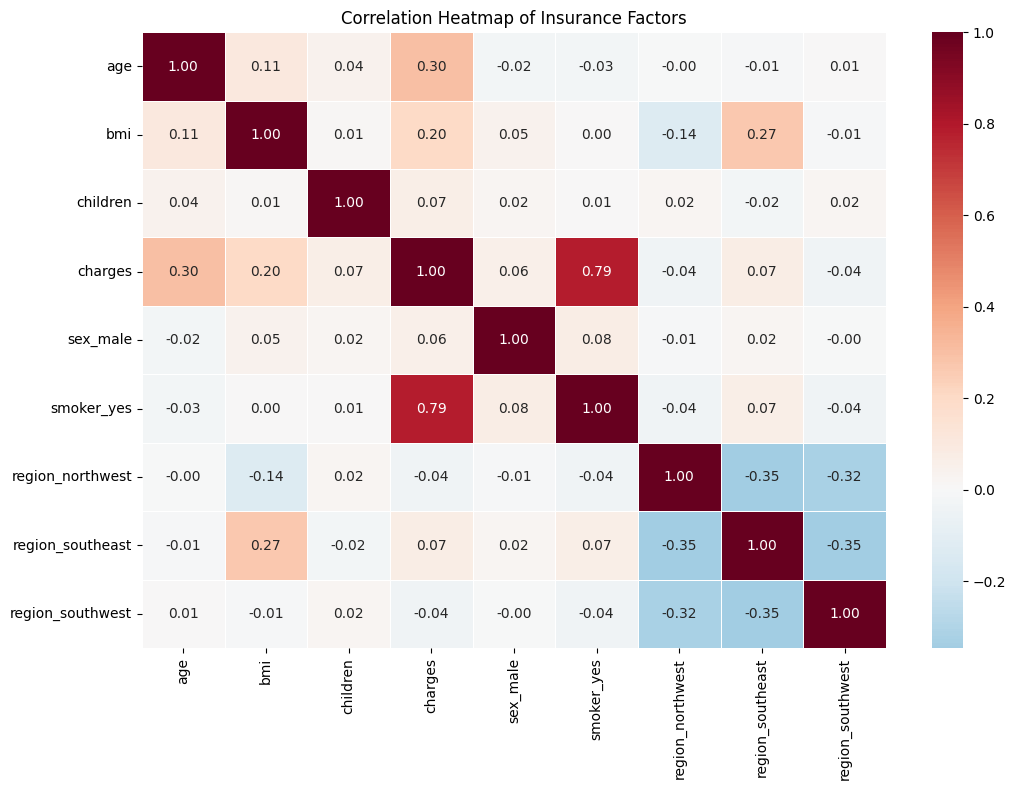

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 計算相關係數矩陣
# 我們直接對 df_encoded 進行計算，這樣可以同時看到類別型變數（編碼後）與數值的關係
corr = df_encoded.corr()

# 設定畫布大小
plt.figure(figsize=(12, 8))

# 繪製熱力圖
# annot=True 顯示數字, cmap 使用冷暖色調, fmt='.2f' 保留兩位小數
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap of Insurance Factors')
plt.show()

In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_poly, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [23]:
y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_poly2_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_poly2_test)))

print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.8408696330537857
R2_score (test):  0.8704327929924432
RMSE:  4850.77693395537
RMSE:  4277.096220340751


In [17]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [19]:
lasso = Lasso(alpha = 0.05) # , positive=True
lasso.fit(X_train,y_train)

y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)

y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.8408696330537857
R2_score (test):  0.8704327929924432
RMSE:  4850.77693395537
RMSE:  4277.096220340751


In [26]:
# Lasso
lasso = Lasso(alpha = 0.05) # , positive=True
lasso.fit(X_train,y_train)

y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)

y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print('R2_score (train): ', r2_score_lasso_train)
print('R2_score (test): ', r2_score_lasso_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.7490732989073342
R2_score (test):  0.7547085242358734
RMSE:  4850.77693395537
RMSE:  4277.096220340751


In [31]:
# 先定義特徵列表 (排除掉目標變數 charges)
# 這樣 zip 的時候，長度才會跟 lasso.coef_ 剛好相等
features = df_encoded.drop('charges', axis=1)

print("coef：")
# for i, j in zip(features.columns, lasso.coef_):
#     print(i, j)
for i, j in zip(features.columns, lasso.coef_):
    # 使用 f-string 讓輸出更整齊，:.2f 保留兩位小數
    print(i, j)


coef：
age 256.0034128874461
bmi 350.6618121265203
children 511.8754006212455
sex_male -25.70333534893745
smoker_yes 24154.576038944542
region_northwest -447.46498223365643
region_southeast -1659.2091430541277
region_southwest -1321.2989761540275


In [ ]:
# 1. 建立並訓練 Ridge 模型
ridgeReg = Ridge(alpha=0.05)
ridgeReg.fit(X_train, y_train)

# 2. 預測與評分
y_pred_ridge_train = ridgeReg.predict(X_train)
r2_score_ridge_train = ridgeReg.score(X_train, y_train)

y_pred_ridge_test = ridgeReg.predict(X_test)
r2_score_ridge_test = ridgeReg.score(X_test, y_test)

rmse_ridge_train = (np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)))
rmse_ridge_test = (np.sqrt(mean_squared_error(y_test, y_pred_ridge_test)))


# 3. 獲取特徵名稱
print("coef：")
for i, j in zip(features.columns, ridgeReg.coef_):
    print(i, j)

coef：
age 255.99881964707933
bmi 350.65822205748304
children 511.98028289060915
sex_male -25.380686233883594
smoker_yes 24147.6926021048
region_northwest -447.6064205813133
region_southeast -1658.7218782267225
region_southwest -1321.3801251420548


In [33]:
print("R2_score (train): ",r2_score_lasso_train)
print("R2_score (test):", r2_score_lasso_test)
print("train_RMSE: ", rmse_lasso_train)
print("test_RMSE: ", rmse_lasso_test)

R2_score (train):  0.7490732989073342
R2_score (test): 0.7547085242358734
train_RMSE:  6091.27504671487
test_RMSE:  5884.948952950345


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# 1. 讀取數據集
# 確保 insurance.csv 檔案放在你的 Python 執行目錄下
df = pd.read_csv('insurance.csv')

In [ ]:
# 2. 進行 One-Hot Encoding
# 使用 dtype=int 確保結果是 0 和 1 而非 True/False
# drop_first=True 移除重複資訊（例如 sex 只有男/女，知道不是男就一定是女，不需兩個欄位）
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=int)


# 資料編碼 (Encoding)我們在 get_dummies 中加入了 dtype=int。
# 這樣做是因為迴歸方程 $y = \beta_0 + \beta_1 x_1 + ...$ 
# 需要純數值運算。smoker_yes = 1：計算時會帶入係數（例如 $23,000 \times 1$）。
# smoker_yes = 0：該項影響力歸零。


print(df_encoded.head())

   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400         0           1                 0   
1   18  33.770         1   1725.55230         1           0                 0   
2   28  33.000         3   4449.46200         1           0                 0   
3   33  22.705         0  21984.47061         1           0                 1   
4   32  28.880         0   3866.85520         1           0                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0  


In [11]:
# 3. 定義特徵 (X) 與 目標 (y)
# X 是我們用來預測的「線索」（年齡、BMI、是否抽菸等）
# y 是我們要預測的「結果」（醫療費用 charges）
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [ ]:
# 4. 分割數據集：70% 訓練集, 30% 測試集
# test_size=0.3 代表測試集佔 30%
# random_state=42 是為了確保每次跑程式碼分割的結果都一樣（方便除錯與結果對照）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 數據分割 (Split)
# 這是資料科學最重要的步驟。

# 訓練集 (X_train, y_train)：像是在課堂上練習題目，讓模型找出「抽菸與高額費用的關聯」。

# 測試集 (X_test, y_test)：像是期末考。我們把 X_test 給模型看，讓它猜費用，
# 再拿它的答案跟真實的 y_test 比對，看它有多準。


In [13]:
# 驗證分割結果
print(f"原始數據筆數: {len(df)}")
print(f"訓練集筆數: {len(X_train)} (70%)")
print(f"測試集筆數: {len(X_test)} (30%)\n")

原始數據筆數: 1338
訓練集筆數: 936 (70%)
測試集筆數: 402 (30%)



In [14]:
# 5. 建立並訓練線性迴歸模型
model = LinearRegression()
model.fit(X_train, y_train) # 讓模型從 70% 的數據中學習規律

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
# R-squared (R²) 解釋在最後的結果中，你會看到一個 R2 分數。
# 如果 $R^2 = 0.75$，代表這個模型能解釋數據中 75% 的變化原因。
# 對於保險數據來說，0.7 以上通常就代表模型非常有參考價值


# 6. 使用測試集進行預測並評估
y_pred = model.predict(X_test)

# 計算模型表現
r2 = r2_score(y_test, y_pred)
print(f"模型的 R-squared (解釋力): {r2:.4f}")
print("這代表模型可以解釋約 {:.2f}% 的費用變動。".format(r2 * 100))

模型的 R-squared (解釋力): 0.7696
這代表模型可以解釋約 76.96% 的費用變動。


In [ ]:
# 解讀影響係數
# 你會發現 smoker_yes 的係數非常巨大（通常在 23,000 美金左右）。
# 這在實務上的意義是：「如果你抽菸，保險公司為了平衡風險，會直接在你的基礎保費上多加這筆錢」。


# 7. 查看影響費用的權重（係數）
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['影響係數'])
print("\n--- 各變量對費用的影響程度 ---")
print(coefficients.sort_values(by='影響係數', ascending=False))


--- 各變量對費用的影響程度 ---
                          影響係數
smoker_yes        23628.367222
children            424.119128
bmi                 348.906915
age                 261.296924
sex_male            104.811823
region_northwest   -486.934610
region_southwest   -926.322908
region_southeast   -970.968839


In [2]:
print("="*80)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [6]:
# 1. 讀取數據與預處理 (同前)
df = pd.read_csv('insurance.csv')
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=int)

X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [ ]:
# 2. 建立多項式特徵
# degree=2 代表我們考慮二次方項與兩兩相乘的交互項
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)


# 特徵轉換 (PolynomialFeatures)
# 這是最關鍵的一步。原本我們的特徵可能只有 age 和 bmi。經過 degree=2 的轉換後，程式會自動幫我們生成：

# age^2, bmi^2
# age * bmi
# age * smoker_yes

# ...以及所有變量的組合。 這讓模型從原本只能畫「直線」變成可以畫出符合數據分布的「複雜曲面」。

In [ ]:
# 3. 分割數據集 (70% 訓練, 30% 測試)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# 數據分割 (70/30 Split)
# 我們依然維持 70/30 的比例。你會發現，因為特徵變多了
# 從原本 8 個變成數十個），模型在訓練集上的表現通常會大幅提升。

In [9]:
# 4. 訓練模型
# 注意：多項式迴歸本質上是在「轉換過的特徵」上跑線性迴歸
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
# 5. 預測與評估
y_pred = poly_model.predict(X_test)


# 評估指標R-squared ($R^2$)：你會發現多項式迴歸的 $R^2$
# 通常會從 0.75 左右提升到 0.80 ~ 0.85。這代表多出來的 10% 預測力，

# 就是來自於那些「曲線」和「交互作用」。MAE (Mean Absolute Error)：
# 這代表平均每一筆預測跟實際費用的誤差金額。多項式模型通常能顯著降低這個誤差。


print(f"多項式迴歸的 R-squared: {r2_score(y_test, y_pred):.4f}")
print(f"平均絕對誤差 (MAE): ${mean_absolute_error(y_test, y_pred):.2f}")

多項式迴歸的 R-squared: 0.8606
平均絕對誤差 (MAE): $2684.66


In [ ]:
# 注意事項：過擬合 (Overfitting)
# 雖然 degree=2 效果很好，但請千萬不要嘗試將 degree 設得太高（例如 5 或 10）。

# 後果：模型會過度去「迎合」訓練集中的每一個噪點，導致它在測試集（未來的病人）上預測得很爛。

# 觀察方法：如果你的訓練集分數很高，但測試集分數很低，那就是過擬合了。

In [1]:
print("="*80)

In [30]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
# LASSO

In [31]:
df = pd.read_csv('insurance.csv')
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=int)

X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [32]:
df_encoded.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [33]:
# 2. 建立多項式特徵 (產生交互項與平方項)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
# 3. 分割數據集 (使用 70/30 比例，random_state 設為固定值)
# 修正：確保我們分割的是 X_poly 而不是原始的 X
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)


# 4. 特徵標準化 (重要：Lasso 模型必備步驟)
# 我們必須讓所有特徵的平均值為 0，標準差為 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # 注意：測試集只需 transform，不可 fit

In [34]:
# 5. 訓練 Lasso 模型
# alpha 是懲罰力度，如果希望篩選掉更多不重要的特徵，可以調大這個值
lasso = Lasso(alpha=1.0, max_iter=10000) 
lasso.fit(X_train_scaled, y_train)

,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",10000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [35]:
# 6. 預測與評估
y_pred_train = lasso.predict(X_train_scaled)
y_pred_test = lasso.predict(X_test_scaled)

In [37]:
# 計算指標
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"訓練集 R2: {r2_train:.4f}, RMSE: {rmse_train:.2f}")
print(f"測試集 R2: {r2_test:.4f}, RMSE: {rmse_test:.2f}")

訓練集 R2: 0.8401, RMSE: 4840.03
測試集 R2: 0.8608, RMSE: 4517.79


In [38]:
# 7. 查看 Lasso 的特徵篩選效果
# 看看有多少特徵的係數被降為 0
total_features = X_poly.shape[1]
active_features = np.sum(lasso.coef_ != 0)
print(f"\n總特徵數 (含多項式): {total_features}")
print(f"Lasso 保留的有效特徵數: {active_features}")


總特徵數 (含多項式): 44
Lasso 保留的有效特徵數: 39
